In [1]:
!git clone --recursive https://github.com/Microsoft/LightGBM 
%cd LightGBM 
!mkdir build
%cd build
!cmake -DUSE_GPU=1 ..
!make -j4
!pip uninstall lightgbm
!cd ../python-package/ && python setup.py install

Cloning into 'LightGBM'...
remote: Enumerating objects: 26767, done.
remote: Counting objects: 100% (3783/3783), done.
remote: Compressing objects: 100% (313/313), done.
remote: Total 26767 (delta 3613), reused 3516 (delta 3466), pack-reused 22984
Receiving objects: 100% (26767/26767), 19.21 MiB | 18.27 MiB/s, done.
Resolving deltas: 100% (19859/19859), done.
Submodule 'include/boost/compute' (https://github.com/boostorg/compute) registered for path 'external_libs/compute'
Submodule 'eigen' (https://gitlab.com/libeigen/eigen.git) registered for path 'external_libs/eigen'
Submodule 'external_libs/fast_double_parser' (https://github.com/lemire/fast_double_parser.git) registered for path 'external_libs/fast_double_parser'
Submodule 'external_libs/fmt' (https://github.com/fmtlib/fmt.git) registered for path 'external_libs/fmt'
Cloning into '/content/LightGBM/external_libs/compute'...
remote: Enumerating objects: 21733, done.        
remote: Counting objects: 100% (5/5), done.        
remot

In [2]:
!pip install sklego

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 224 kB 5.0 MB/s 
     |████████████████████████████████| 88 kB 7.3 MB/s 
     |████████████████████████████████| 1.1 MB 39.2 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=c16730d3c4ae4503a3a218b6e19053af3e02257913978591b3ff351547610eb8
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.7-py3-none-any.whl size=54286 sha256=7ae8bd9539faf058274df87e6d2e3f9371a0340bfb7b3615888598b47965bc30
  Stored in directory: /root/.cache/pip/wheels/7f/2a/f8/7bd5dcec71bd5c669f6f574db3113513696b98f3f9b51f496c
Successfully built umap-learn pynndescent


In [3]:
%cd ../../

/content


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, PowerTransformer
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

from lightgbm import LGBMClassifier

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis

from sklego.mixture import BayesianGMMClassifier

In [5]:
PATH = 'drive/MyDrive/Kaggle/Clustering_072022/'

df = pd.read_csv(PATH + 'src/data_removed.csv', index_col='id')
cat_feats = df.columns[df.dtypes == 'int']
num_feats = df.columns[df.dtypes == 'float']
best_cols = df.columns

df[num_feats] = RobustScaler().fit_transform(df[num_feats])
X_scaled = pd.DataFrame(PowerTransformer().fit_transform(df), columns=df.columns)

In [6]:
bgmm = BayesianGaussianMixture(n_components=7, covariance_type = 'full', n_init=3, random_state=2)
predicted_class = bgmm.fit_predict(X_scaled)
df["class"] = predicted_class

In [7]:
def score_clusters(X, predictions, silhouette = False, verbose=False):
    """Evaluate how good our cluster label predictions are"""
    
    db_score = davies_bouldin_score(X=X, labels=predictions)

    ch_score = calinski_harabasz_score(X=X, labels=predictions)
    #the silhouette score is the slowest to compute ~90 secs
    #s_score = silhouette_score(X=X, labels=predictions, metric='euclidean')
    
    if verbose:
        print("David Bouldin score: {0:0.4f}".format(db_score))
        print("Calinski Harabasz score: {0:0.3f}".format(ch_score))
        #print("Silhouette score: {0:0.4f}".format(s_score))
        
    return db_score, ch_score #,s_score

In [8]:
def soft_voting(predict_number, best_cols = best_cols):
    #initialise dataframe with 0's
    predicted_probabilities = pd.DataFrame(np.zeros((len(df),7)), columns=range(1,8))
    # loop with a different random seeds
    for i in range(predict_number):
        print("=========", i, "==========")
        X_scaled_sample = X_scaled.sample(40000, replace=True)
        gmm = BayesianGaussianMixture(n_components=7, covariance_type = 'full', max_iter=100, init_params="kmeans", n_init=2, random_state=i, tol=0.05)
        gmm.fit(X_scaled_sample[best_cols])
        pred_probs = gmm.predict_proba(X_scaled[best_cols])
        pred_probs = pd.DataFrame(pred_probs, columns=range(1,8))
        
        # ensuring clusters are labeled the same value at each fit
        if i == 0:
            initial_centers = gmm.means_
        new_classes = []
        for mean2 in gmm.means_:
            #for the current center of the current gmm, find the distances to every center in the initial gmm
            distances = [np.linalg.norm(mean1-mean2) for mean1 in initial_centers]
            # select the class with the minimum distance
            new_class = np.argmin(distances) + 1 #add 1 as our labels are 1-7 but index is 0-6
            new_classes.append(new_class)
        # if the mapping from old cluster labels to new cluster labels isn't 1 to 1
        if len(new_classes) != len(set(new_classes)):
            print("iteration", i, "could not determine the cluster label mapping, skipping")
            continue
        #apply the mapping by renaming the dataframe columns representing the original labels to the new labels    
        pred_probs = pred_probs.rename(columns=dict(zip(range(1,8),new_classes)))
        
        #add the current prediction probabilities to the overall prediction probabilities
        predicted_probabilities = predicted_probabilities + pred_probs
        # lets score the cluster labels each iteration to see if soft voting is helpful
        score_clusters(X_scaled[best_cols], predicted_probabilities.idxmax(axis=1), verbose=True)
    
    #normalise dataframe so each row sums to 1
    predicted_probabilities = predicted_probabilities.div(predicted_probabilities.sum(axis=1), axis=0)
    return predicted_probabilities

In [9]:
pred_probs = soft_voting(100)

========= 0 ==========
David Bouldin score: 3.7510
Calinski Harabasz score: 3879.891
========= 1 ==========
David Bouldin score: 3.6698
Calinski Harabasz score: 3830.971
========= 2 ==========
David Bouldin score: 3.6352
Calinski Harabasz score: 3814.801
========= 3 ==========
David Bouldin score: 3.6653
Calinski Harabasz score: 3835.011
========= 4 ==========
David Bouldin score: 3.6408
Calinski Harabasz score: 3818.848
========= 5 ==========
David Bouldin score: 3.6722
Calinski Harabasz score: 3832.085
========= 6 ==========
David Bouldin score: 3.7099
Calinski Harabasz score: 3863.850
========= 7 ==========
David Bouldin score: 3.6691
Calinski Harabasz score: 3829.492
========= 8 ==========
David Bouldin score: 3.6472
Calinski Harabasz score: 3816.735
========= 9 ==========
David Bouldin score: 3.6444
Calinski Harabasz score: 3812.285
========= 10 ==========
David Bouldin score: 3.6422
Calinski Harabasz score: 3810.019
========= 11 ==========
David Bouldin score: 3.6379
Calinski Har

/usr/local/lib/python3.7/dist-packages/sklearn/mixture/_base.py:282: ConvergenceWarning: Initialization 2 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,


iteration 17 could not determine the cluster label mapping, skipping
========= 18 ==========
David Bouldin score: 3.6342
Calinski Harabasz score: 3813.136
========= 19 ==========
David Bouldin score: 3.6326
Calinski Harabasz score: 3812.550
========= 20 ==========
David Bouldin score: 3.6367
Calinski Harabasz score: 3812.248
========= 21 ==========
David Bouldin score: 3.6369
Calinski Harabasz score: 3814.426
========= 22 ==========
iteration 22 could not determine the cluster label mapping, skipping
========= 23 ==========
David Bouldin score: 3.6371
Calinski Harabasz score: 3813.051
========= 24 ==========
David Bouldin score: 3.6364
Calinski Harabasz score: 3811.825
========= 25 ==========
David Bouldin score: 3.6357
Calinski Harabasz score: 3811.338
========= 26 ==========
David Bouldin score: 3.6336
Calinski Harabasz score: 3811.848
========= 27 ==========
David Bouldin score: 3.6330
Calinski Harabasz score: 3811.401
========= 28 ==========
David Bouldin score: 3.6315
Calinski Har

/usr/local/lib/python3.7/dist-packages/sklearn/mixture/_base.py:282: ConvergenceWarning: Initialization 2 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,


David Bouldin score: 3.6307
Calinski Harabasz score: 3808.680
========= 31 ==========
David Bouldin score: 3.6285
Calinski Harabasz score: 3810.323
========= 32 ==========
David Bouldin score: 3.6282
Calinski Harabasz score: 3809.928
========= 33 ==========
David Bouldin score: 3.6291
Calinski Harabasz score: 3810.255
========= 34 ==========
David Bouldin score: 3.6288
Calinski Harabasz score: 3810.387
========= 35 ==========
David Bouldin score: 3.6304
Calinski Harabasz score: 3811.299
========= 36 ==========
David Bouldin score: 3.6300
Calinski Harabasz score: 3810.678
========= 37 ==========
David Bouldin score: 3.6297
Calinski Harabasz score: 3810.187
========= 38 ==========
iteration 38 could not determine the cluster label mapping, skipping
========= 39 ==========
David Bouldin score: 3.6293
Calinski Harabasz score: 3810.549
========= 40 ==========
David Bouldin score: 3.6281
Calinski Harabasz score: 3811.121
========= 41 ==========
David Bouldin score: 3.6262
Calinski Harabasz s

/usr/local/lib/python3.7/dist-packages/sklearn/mixture/_base.py:282: ConvergenceWarning: Initialization 2 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,


David Bouldin score: 3.6281
Calinski Harabasz score: 3812.804
========= 96 ==========
iteration 96 could not determine the cluster label mapping, skipping
========= 97 ==========
David Bouldin score: 3.6273
Calinski Harabasz score: 3813.299
========= 98 ==========
David Bouldin score: 3.6271
Calinski Harabasz score: 3812.924
========= 99 ==========
David Bouldin score: 3.6278
Calinski Harabasz score: 3813.309


In [10]:
%%time
score_clusters(X_scaled[best_cols],pred_probs.idxmax(axis=1), verbose=True, silhouette = False)

David Bouldin score: 3.6278
Calinski Harabasz score: 3813.309
CPU times: user 210 ms, sys: 95.5 ms, total: 305 ms
Wall time: 207 ms


(3.627777522953327, 3813.3088740673775)

In [11]:
def best_class(df):
    new_df = df.copy()
    new_df["highest_prob"] = df.max(axis=1)
    new_df["best_class"] = df.idxmax(axis=1)
    new_df["second_highest_prob"] = df.apply(lambda x: x.nlargest(2).values[-1], axis=1)
    new_df["second_best_class"] = df.apply(lambda x: np.where(x == x.nlargest(2).values[-1])[0][0]+1, axis=1)
    return new_df

In [12]:
cluster_class_probs = best_class(pred_probs)

In [13]:
cluster_class_probs['difference'] = cluster_class_probs['highest_prob'] - cluster_class_probs['second_highest_prob']
cluster_class_probs.describe()

,1,2,3,4,5,6,7,highest_prob,best_class,second_highest_prob,second_best_class,difference
count,9.800000e+04,9.800000e+04,9.800000e+04,9.800000e+04,9.800000e+04,9.800000e+04,9.800000e+04,98000.000000,98000.000000,9.800000e+04,98000.000000,98000.000000
mean,1.706972e-01,1.392620e-01,1.166341e-01,1.586006e-01,1.629039e-01,1.201029e-01,1.317992e-01,0.818378,3.863643,1.302452e-01,4.125827,0.688133
std,3.111619e-01,3.005091e-01,2.714550e-01,2.956978e-01,3.140485e-01,2.338304e-01,3.102659e-01,0.184718,2.008586,1.325421e-01,1.834702,0.311072
min,2.894438e-22,7.256123e-21,6.471820e-21,1.163958e-19,2.010178e-21,1.367118e-17,3.364161e-27,0.220507,1.000000,4.467353e-13,1.000000,0.000004
25%,8.906586e-05,1.198132e-05,1.021615e-05,1.113554e-04,2.871852e-05,2.186252e-04,2.756679e-07,0.683489,2.000000,1.363267e-02,3.000000,0.449306
50%,4.639179e-03,9.037766e-04,6.034156e-04,4.621561e-03,2.331302e-03,7.082899e-03,8.883190e-05,0.888532,4.000000,8.027399e-02,4.000000,0.805454
75%,1.409791e-01,4.057367e-02,2.873188e-02,1.227050e-01,9.538233e-02,1.033539e-01,1.022752e-02,0.980883,5.000000,2.270901e-01,6.000000,0.966809
max,9.999999e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,9.999972e-01,1.000000e+00,1.000000,7.000000,4.997427e-01,7.000000,1.000000


In [19]:
cluster_class_probs.sort_values(by='difference').head(100)

,1,2,3,4,5,6,7,highest_prob,best_class,second_highest_prob,second_best_class,difference
88418,0.297706,0.024473,0.297702,0.101160,2.981249e-03,2.759750e-01,2.432912e-06,0.297706,1,0.297702,3,0.000004
29104,0.000022,0.398762,0.398698,0.002162,1.714328e-01,2.848469e-02,4.396111e-04,0.398762,2,0.398698,3,0.000064
7422,0.321636,0.004054,0.103873,0.321570,1.645858e-01,8.410446e-02,1.761840e-04,0.321636,1,0.321570,4,0.000066
97711,0.450223,0.005378,0.019649,0.067799,6.799960e-03,4.501490e-01,1.774602e-06,0.450223,1,0.450149,6,0.000074
33227,0.326603,0.002441,0.000485,0.055135,2.608772e-01,3.266781e-01,2.778043e-02,0.326678,6,0.326603,1,0.000075
...,...,...,...,...,...,...,...,...,...,...,...,...
29127,0.498314,0.000066,0.000020,0.000013,1.624188e-04,4.969086e-01,4.516175e-03,0.498314,1,0.496909,6,0.001405
41998,0.000359,0.483355,0.481922,0.034363,1.146324e-08,8.829961e-07,1.397563e-13,0.483355,2,0.481922,3,0.001433
71206,0.010298,0.362518,0.000158,0.361040,2.759467e-05,2.657311e-01,2.268850e-04,0.362518,2,0.361040,4,0.001478
47853,0.311396,0.000373,0.000262,0.004886,3.281636e-01,2.525129e-02,3.296687e-01,0.329669,7,0.328164,5,0.001505


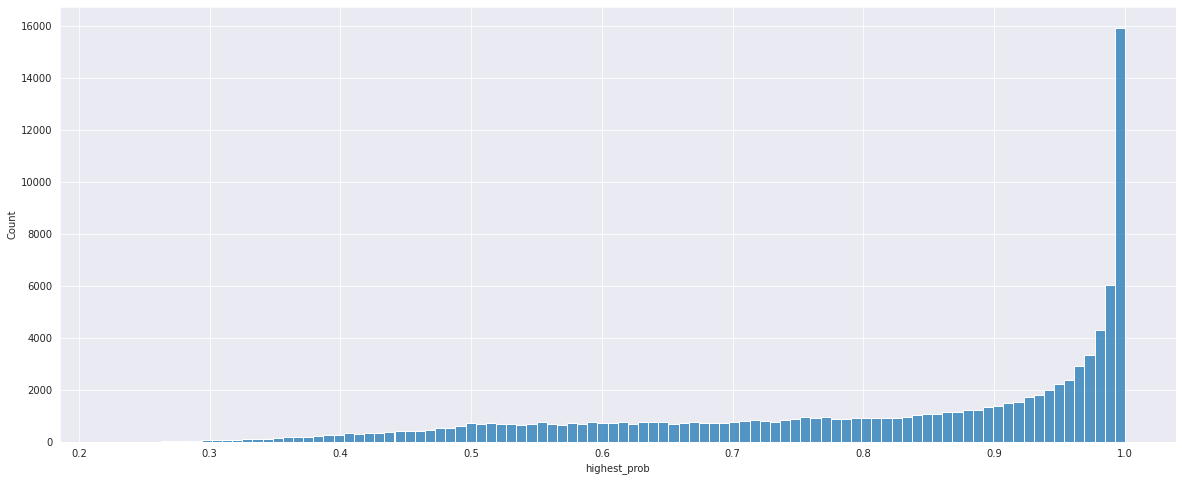

In [21]:
plt.figure(figsize=(20, 8))
sns.histplot(cluster_class_probs['highest_prob'], bins=100)

(0.65, 0.95)

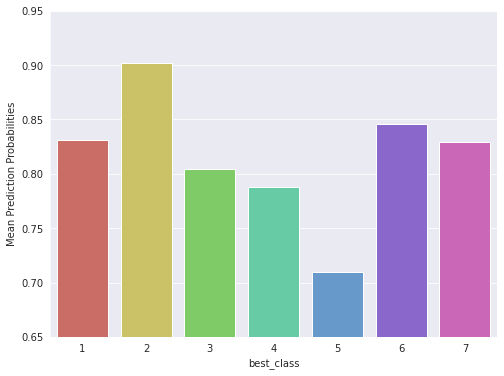

In [22]:
confidence_s = cluster_class_probs.groupby('best_class')['highest_prob'].mean()
fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(x=confidence_s.index, y=confidence_s.values, palette=sns.color_palette('hls', 7))
ax.set_ylabel('Mean Prediction Probabilities')
ax.set_ylim([0.65, 0.95])

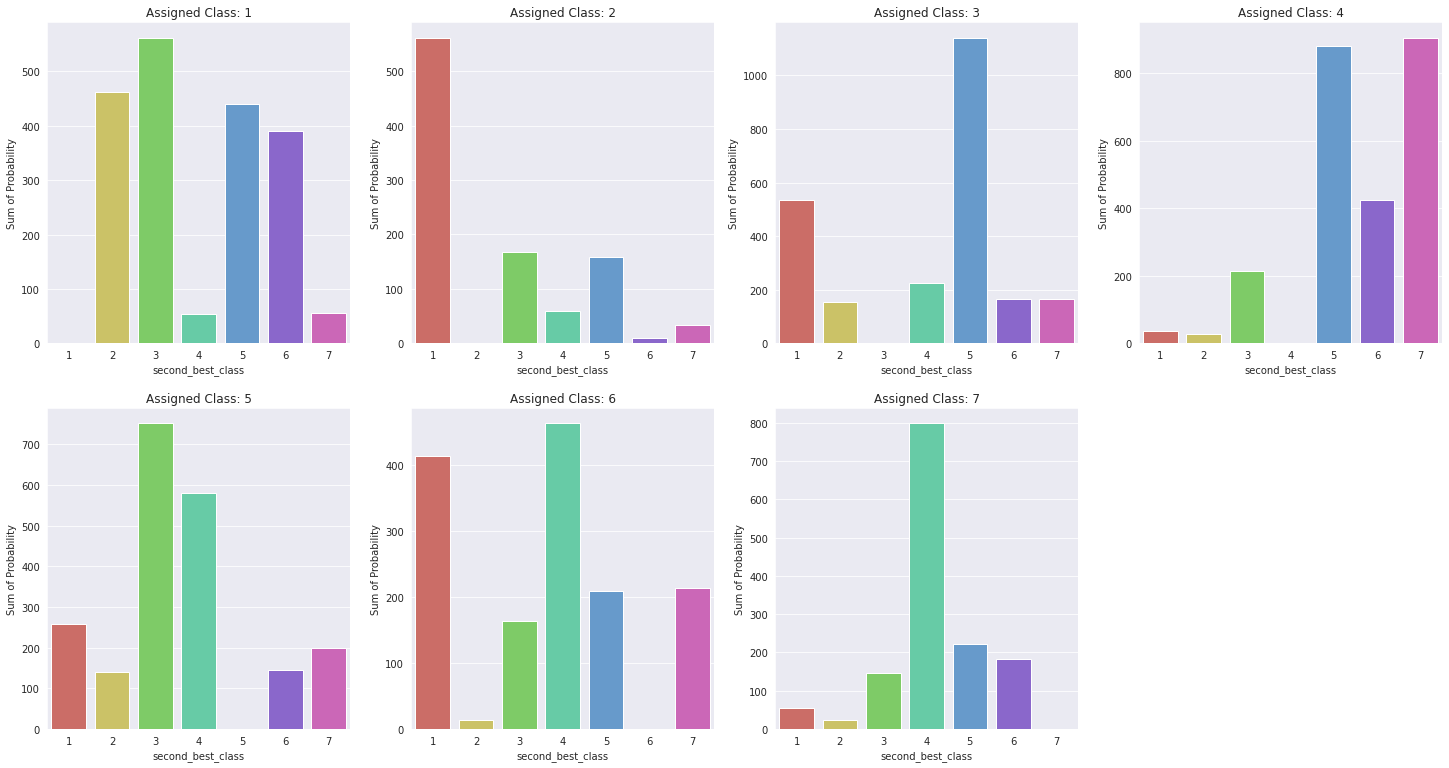

In [23]:
second_highest_probs_sum = cluster_class_probs.groupby(['best_class', 'second_best_class'])['second_highest_prob'].sum().reset_index()

fig, ax = plt.subplots(figsize=(25, 13))
tmp_df = pd.DataFrame({'second_best_class': range(1, 8)})
for i in range(1, 8):
    second_best_match = second_highest_probs_sum.loc[second_highest_probs_sum['best_class']==i, ['second_best_class', 'second_highest_prob']]
    plot_df = pd.merge(left=tmp_df, right=second_best_match, on='second_best_class', how='left')
    ax = plt.subplot(2, 4, i)
    sns.barplot(data=plot_df, x='second_best_class', y='second_highest_prob', palette=sns.color_palette('hls', 7))
    ax.set_ylabel('Sum of Probability')
    ax.set_title('Assigned Class: ' + str(i))

In [24]:
confident_predictions = cluster_class_probs.loc[cluster_class_probs['highest_prob'] >= 0.85]
confident_preds_class = confident_predictions['best_class']
X_scaled['class'] = confident_preds_class

In [25]:
train_df = X_scaled.loc[X_scaled["class"] == X_scaled["class"]]
test_df = X_scaled.loc[X_scaled["class"] != X_scaled["class"]]

In [26]:
X = train_df.drop(columns="class").reset_index(drop=True)
y = train_df["class"].reset_index(drop=True)
X_test = test_df.drop(columns="class").reset_index(drop=True)
X_full = X_scaled.drop(columns="class")

In [27]:
et = ExtraTreesClassifier(n_estimators = 2000,
                                n_jobs = -1,
                                random_state=42
                               )

In [28]:
lgb = LGBMClassifier(objective = 'multiclass',
                            n_estimators = 5000,
                            random_state = 42,
                            learning_rate = 0.1,
                            n_jobs = -1,
                            device_type='gpu')

In [29]:
qda = QuadraticDiscriminantAnalysis()
lda = LinearDiscriminantAnalysis()

In [30]:
bgmm = BayesianGMMClassifier(
            n_components=7,
            random_state = 1,
            tol =1e-3,
            covariance_type = 'full',
            max_iter = 400,
            n_init=4,
            init_params='kmeans')

In [31]:
models = {"ET":et, "LGBM":lgb, "QDA":qda, "LDA":lda, "BGMM_C":bgmm}

In [32]:
def k_fold_cv(model, X, y, verbose=True):
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

    feat_imp, y_pred_list, y_true_list, acc_list = [], [], [], []
    for fold, (trn_idx, val_idx) in enumerate(kfold.split(X, y)):
        if verbose: print('=========='*10+f'\n Fold number: {fold}')
        X_train = X.loc[trn_idx]
        X_val = X.loc[val_idx]

        y_train = y.loc[trn_idx]
        y_val = y.loc[val_idx]

        model.fit(X_train, y_train)

        y_pred = model.predict(X_val)

        y_pred_list = np.append(y_pred_list, y_pred)
        y_true_list =- np.append(y_true_list, y_val)

        acc_list.append(accuracy_score(y_pred, y_val))
        if verbose: print(f'Accuracy Score: {acc_list[-1]}')
        try:
            feat_imp.append(model.feature_importances_)
        except AttributeError:
            pass

    return feat_imp, y_pred_list, y_true_list, acc_list, X_val, y_val

In [33]:
def evaluate_models():
    for model_name, model in models.items():
        print(f'==='*10, model_name, '==='*10)
        feat_imp, y_pred_list, y_true_list, acc_list, X_val, y_val = k_fold_cv(model=model, X=X, y=y, verbose=True)
        acc_score = accuracy_score(y_pred_list, y_true_list)
        print('{0:0.4f}'.format(acc_score))

In [34]:
evaluate_models()

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

In [35]:
feature_imp, y_pred_list, y_true_list, acc_list, X_val, y_val = k_fold_cv(model=lgb,X=X,y=y)

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

In [36]:
def plot_feature_importances(model_importances, feature_names, model_name, n_folds=5, ax=None, boxplot=False):
    importances_df = pd.DataFrame({'feature_cols': feature_names, 'importances_fold_0': model_importances[0]})
    for i in range(1, n_folds):
        importances_df[f'importances_fold_{i}'] = model_importances[i]
    importances_df['importances_fold_median'] = importances_df.drop('feature_cols', axis=1).median(axis=1)
    importances_df = importances_df.sort_values(by='importances_fold_median', ascending=False)
    if ax == None:
        fig, ax = plt.subplots(figsize=(15, 25))
    if boxplot == False:
        ax = sns.barplot(data=importances_df, x='importances_fold_median', y='feature_cols', color='blue')
        ax.set_xlabel('Median Feature Importance Across Folds')
    elif boxplot == True:
        importances_df = importances_df.drop('importances_fold_median', axis=1)
        importances_df = importances_df.set_index('feature_cols').stack().reset_index().rename(columns={0: 'feature_importance'})
        ax = sns.boxplot(data=importances_df, y='feature_cols', x='feature_importance', color='blue', orient='h')
        ax.set_xlabel('Feature Importance Across Folds')
    plt.title(model_name)
    ax.set_ylabel('Feature Names')
    return ax

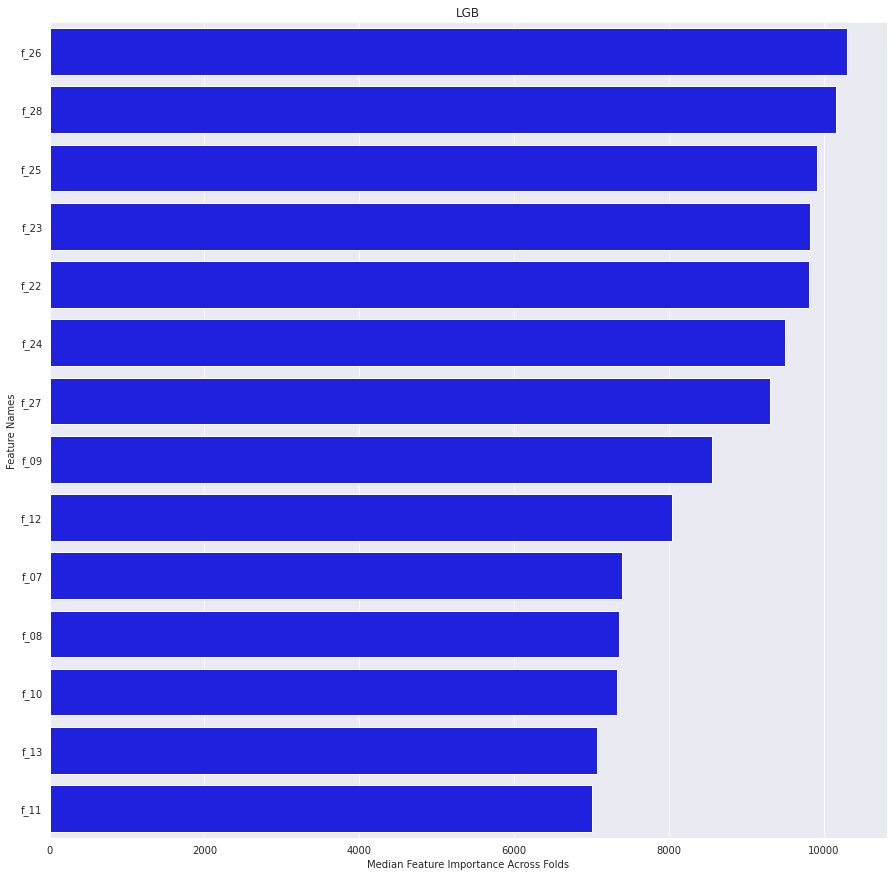

In [37]:
fig, ax = plt.subplots(figsize=(15, 15))
plot_feature_importances(model_importances=feature_imp, feature_names=X_val.columns, model_name='LGB', n_folds=2, ax=ax, boxplot=False)

# Inference

In [38]:
def fit_predict_everything():
    preds = []
    model_names = []
    scores = []
    for model_name, model in models.items():
        print('===', model_name, '===')
        model.fit(X[best_cols], y)
        preds_prob = model.predict_proba(X_full[best_cols])
        preds_prob_df = pd.DataFrame(preds_prob, columns=range(1, 8), index=X_scaled.index)
        db, ch = score_clusters(X_scaled[best_cols], preds_prob_df.idxmax(axis=1), verbose=True)
        scores.append((db, ch))
        preds.append(preds_prob_df)
        model_names.append(model_name)

    return preds, model_names, scores

In [ ]:
import pickle
pickle.dump(pred_probs, open(PATH+'src/ensemble_pred_probs2.pkl', 'wb'))

In [39]:
predictions, model_names, scores = fit_predict_everything()

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

In [40]:
cluster_class_probs = cluster_class_probs.loc[:, [1, 2, 3, 4, 5, 6, 7]]
predictions.append(cluster_class_probs)
model_names.append('BGMM')

In [41]:
db, ch = score_clusters(X_scaled[best_cols], cluster_class_probs.idxmax(axis=1), verbose=True)
scores.append((db, ch))

David Bouldin score: 3.6285
Calinski Harabasz score: 3812.188


# Combine Predictions

In [42]:
#chosen fairly randomly
predictions_df = 0.5 * predictions[0] + 1.5 * predictions[1] + 0.5 * predictions[2] + 1.5 * predictions[4] + 0.5 * predictions[5]

#normalise so rows sums to 1
predictions_df = predictions_df.div(predictions_df.sum(axis=1), axis=0)
predictions_df = best_class(predictions_df)

In [43]:
db, ch = score_clusters(X_scaled[best_cols], predictions_df["best_class"], verbose=True)
scores.append((db,ch))
model_names.append("combined")

David Bouldin score: 3.5633
Calinski Harabasz score: 3922.873


In [44]:
pd.DataFrame(scores, index=model_names, columns=["Davies-Bouldin Index","Calinski-Harabasz Index"])

,Davies-Bouldin Index,Calinski-Harabasz Index
ET,3.425583,4014.488108
LGBM,3.582482,3907.100838
QDA,3.560626,3939.709489
LDA,3.089330,4606.221228
BGMM_C,3.610449,3844.921737
BGMM,3.628469,3812.188338
combined,3.563305,3922.872770


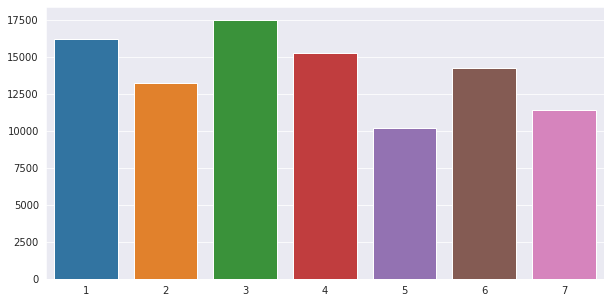

In [45]:
fig, ax = plt.subplots(figsize=(10,5))
val_c = predictions_df["best_class"].value_counts()
sns.barplot(x=val_c.index, y=val_c.values)

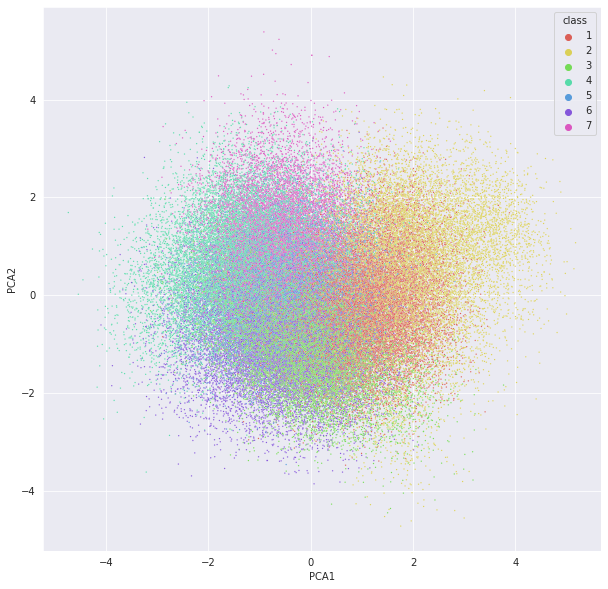

In [46]:
pca = PCA(n_components=2, random_state=10)
X_pca = pca.fit_transform(X_scaled[best_cols])
pca_df = pd.DataFrame({'PCA1': X_pca[:, 0], 'PCA2': X_pca[:, 1]})
pca_df['class'] = predictions_df['best_class']

fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='class', s=2, palette=sns.color_palette('hls', pca_df['class'].nunique()))

(0.4, 0.95)

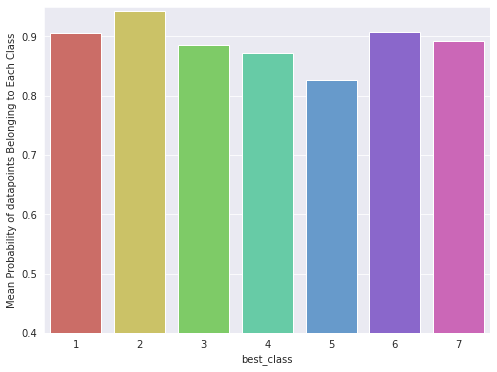

In [47]:
confidence_s = predictions_df.groupby('best_class')['highest_prob'].mean()
fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(x=confidence_s.index, y=confidence_s.values, palette=sns.color_palette('hls', 7))
ax.set_ylabel('Mean Probability of datapoints Belonging to Each Class')
ax.set_ylim([0.4, 0.95])

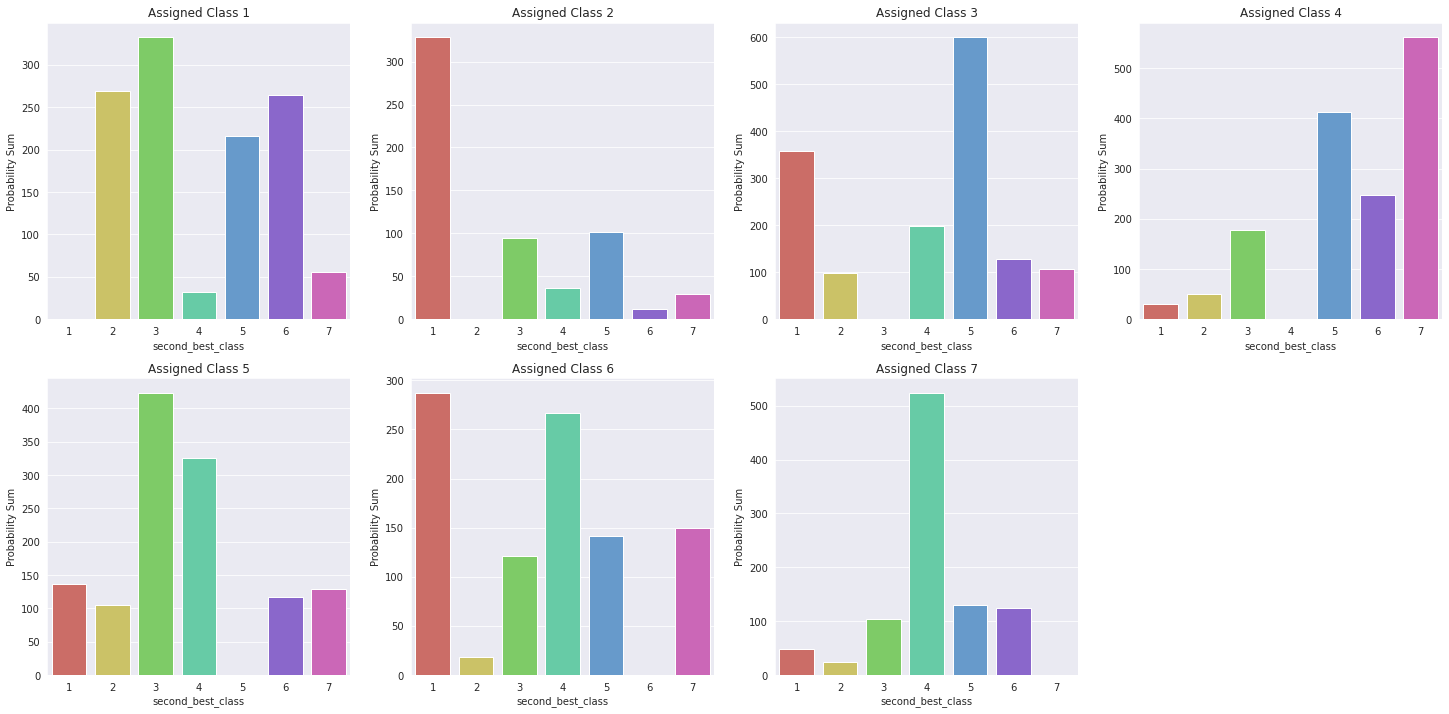

In [48]:
second_highest_probs_sum = predictions_df.groupby(['best_class', 'second_best_class'])['second_highest_prob'].sum().reset_index()
fig, ax = plt.subplots(figsize=(25, 12))
tmp_df = pd.DataFrame({'second_best_class': range(1, 8)})

for i in range(1, 8):
    second_best_match = second_highest_probs_sum.loc[second_highest_probs_sum['best_class'] == i, ['second_best_class', 'second_highest_prob']]
    plt_df = pd.merge(left=tmp_df, right=second_best_match, how='left', on='second_best_class')
    ax = plt.subplot(2, 4, i)
    sns.barplot(data=plt_df, x='second_best_class', y='second_highest_prob', palette=sns.color_palette('hls', 7))
    ax.set_ylabel('Probability Sum')
    ax.set_title(f'Assigned Class {i}')

In [49]:
def update_predictions(predict_number, y):
    for i in range(predict_number):
        print('==='*6, i, '==='*6)
        X_scaled_sample = X_scaled.sample(60000)
        y_sample = y.loc[X_scaled_sample.index]

        bgmm = BayesianGMMClassifier(
            n_components=7,
            random_state=i,
            n_init=3, max_iter=200,
            tol=0.05,
            init_params='kmeans'
        )
        bgmm.fit(X_scaled_sample[best_cols], y_sample)

        pred_probs = bgmm.predict_proba(X_scaled[best_cols])
        pred_probs = pd.DataFrame(pred_probs, columns=range(1,8))

        score_clusters(X_scaled[best_cols], pred_probs.idxmax(axis=1), verbose=True)
        y = pred_probs.idxmax(axis=1)

    return pred_probs

In [50]:
predicted_probabilities = update_predictions(predict_number=200, y=predictions_df["best_class"])

================== 0 ==================
David Bouldin score: 3.6441
Calinski Harabasz score: 3791.429
================== 1 ==================
David Bouldin score: 3.7017
Calinski Harabasz score: 3701.335
================== 2 ==================
David Bouldin score: 3.7549
Calinski Harabasz score: 3645.670
================== 3 ==================
David Bouldin score: 3.7950
Calinski Harabasz score: 3606.219
================== 4 ==================
David Bouldin score: 3.8149
Calinski Harabasz score: 3585.173
================== 5 ==================
David Bouldin score: 3.8369
Calinski Harabasz score: 3567.576
================== 6 ==================
David Bouldin score: 3.8487
Calinski Harabasz score: 3557.806
================== 7 ==================
David Bouldin score: 3.8534
Calinski Harabasz score: 3553.475
================== 8 ==================
David Bouldin score: 3.8595
Calinski Harabasz score: 3550.697
================== 9 ==================
David Bouldin score: 3.8660
Calinski Harab

In [51]:
predictions_df = best_class(predicted_probabilities)

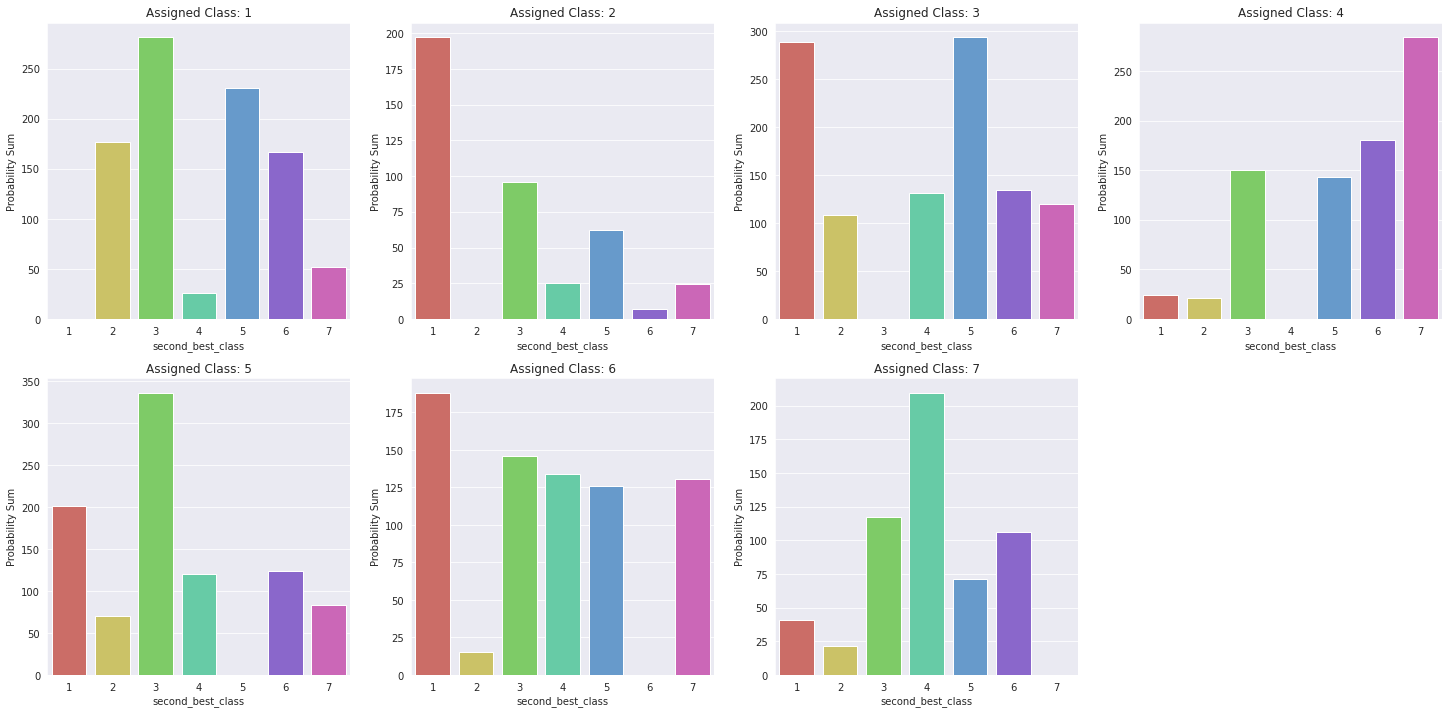

In [52]:
second_highest_probs_sum = predictions_df.groupby(['best_class', 'second_best_class'])['second_highest_prob'].sum().reset_index()

fig, ax = plt.subplots(figsize=(25, 12))
tmp_df = pd.DataFrame({'second_best_class': range(1, 8)})
for i in range(1, 8):
    second_best_match = second_highest_probs_sum.loc[second_highest_probs_sum['best_class'] == i, ['second_best_class', 'second_highest_prob']]
    plot_df = pd.merge(left=tmp_df, right=second_best_match, how='left', on='second_best_class')
    ax = plt.subplot(2, 4, i)
    sns.barplot(data=plot_df, x='second_best_class', y='second_highest_prob', palette=sns.color_palette('hls', 7))
    ax.set_ylabel('Probability Sum')
    ax.set_title(f'Assigned Class: {i}')

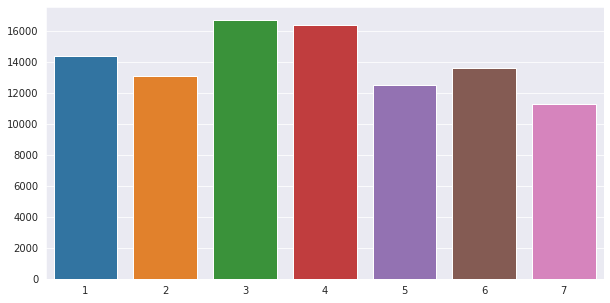

In [53]:
fig, ax = plt.subplots(figsize=(10, 5))
val_c = predictions_df['best_class'].value_counts()
sns.barplot(x=val_c.index, y=val_c.values)

In [54]:
submission = pd.read_csv(PATH + 'submissions/sample_submission.csv', index_col='Id')
submission['Predicted'] = predictions_df['best_class']
submission.to_csv(PATH + 'submissions/ensemble#4-sampled_with_replacement_smallersample_moreiter.csv')